# Geo-economic Clustering

The objective of this task was to make 10 clusters based on countries GDP and geographical position.

Data used:
    
- World bank databank: GDP historical (from 1960 aprox.), GDP 2019 and 2019 world population by country (excel files).
- JSON file with countries coordinates (latitude and longitude)

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN

## Data

First I want to combine two separate files:
- Worldbank information with each country GDP in 2019
- Countries coordinates JSON

In [3]:
# Loading GDP info from data worldbank (2019)

data = pd.read_excel("GDP_2019.xlsx", encoding='utf-8')
populations = pd.read_excel("populations.xlsx", encoding='utf-8')

# Getting JSON geocoordinates from countries
url = "https://raw.githubusercontent.com/eesur/country-codes-lat-long/master/country-codes-lat-long-alpha3.json"
resp = requests.get(url)
coords = json.loads(resp.text)

In [4]:
data.head()

,Country Code,Country,GDP (millions of dollars)
0,USA,United States,2.142770e+07
1,CHN,China,1.434290e+07
2,JPN,Japan,5.081770e+06
3,DEU,Germany,3.845630e+06
4,IND,India,2.875142e+06


In [5]:
data.shape

(217, 3)

In [6]:
coords["ref_country_codes"][0]

{'country': 'Albania',
 'alpha2': 'AL',
 'alpha3': 'ALB',
 'numeric': 8,
 'latitude': 41,
 'longitude': 20}

In [7]:
len(coords["ref_country_codes"])

243

In a first look maybe there are some missing countries in the JSON file or repeated countries in the World bank data.

## Data Cleaning

- I will drop the countries with no GDP, which normally are not relevant countries (in economical terms, globally speaking).

In [8]:
for i in data['GDP (millions of dollars)']:
    if i in ['--','-','NaN','NA','None',None,np.nan,'?', 0.0]:
        print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [9]:
data = data[data['GDP (millions of dollars)'] != 0.0]

data.reset_index(drop=True, inplace = True)

In [10]:
data.head(3)

,Country Code,Country,GDP (millions of dollars)
0,USA,United States,2.142770e+07
1,CHN,China,1.434290e+07
2,JPN,Japan,5.081770e+06


In [11]:
for i in data['GDP (millions of dollars)']:
    if i == 0.0:
        print(i)

In [12]:
data.shape

(203, 3)

- Then I want to check if the country codes in the worldbank data are correct or need to be fixed:

In [13]:
names = []
codes_json1 = []
codes_json2 = []
codes_worldbank = []

for name,code in zip(data['Country'], data['Country Code']):
    for json_index in range(0, len(coords["ref_country_codes"])):
        if coords["ref_country_codes"][json_index]['country'] == name:
            codes_json1.append(coords["ref_country_codes"][json_index]['alpha2'])
            codes_json2.append(coords["ref_country_codes"][json_index]['alpha3'])
            codes_worldbank.append(code)
            names.append(name)

In [14]:
df_codes = pd.DataFrame(list(zip(names, codes_worldbank, codes_json1, codes_json2)), 
               columns =['Name', 'code_worldbank', 'code_json1', 'code_json2'])

df_codes.head()

,Name,code_worldbank,code_json1,code_json2
0,United States,USA,US,USA
1,China,CHN,CN,CHN
2,Japan,JPN,JP,JPN
3,Germany,DEU,DE,DEU
4,India,IND,IN,IND


The woldbank country codes seem to be equal to one of the json country codes

In [15]:
df_codes['code_worldbank'].equals(df_codes['code_json2'])

True

All the world bank countries codes are equal to the json countries codes.

- Finally I want to join the worldbank data with the longitude and latitude of each country from the json file:

In [16]:
country_code = []
names = []
GDP = []
lat = []
lon = []
missing_country_data = []

for code, GDP_data, name in zip(data['Country Code'], data['GDP (millions of dollars)'], data['Country']):
    for j in range(0, len(coords["ref_country_codes"])):
        if code in coords["ref_country_codes"][j].values():
            lat.append(coords["ref_country_codes"][j]['latitude'])
            lon.append(coords["ref_country_codes"][j]['longitude'])
            country_code.append(code)
            GDP.append(GDP_data)
            names.append(name)

In [17]:
data_complete = pd.DataFrame(list(zip(names, country_code, lat, lon, GDP)), 
               columns =['Country Name','code', 'lat', 'lon', 'GDP (millions of dollars)'])

data_complete.head()

,Country Name,code,lat,lon,GDP (millions of dollars)
0,United States,USA,38.0,-97.0,2.142770e+07
1,China,CHN,35.0,105.0,1.434290e+07
2,Japan,JPN,36.0,138.0,5.081770e+06
3,Germany,DEU,51.0,9.0,3.845630e+06
4,India,IND,20.0,77.0,2.875142e+06


In [18]:
data.shape

(203, 3)

In [19]:
data_complete.shape

(201, 5)

Two countries were missing. Maybe there were duplicates.

## Data Analysis

### Data distribution

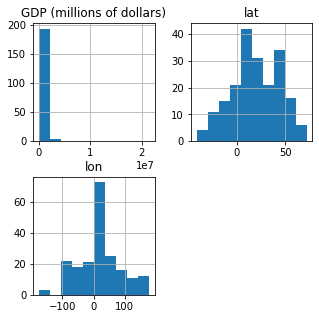

In [20]:
data_distribution = data_complete.hist(figsize=(5,5))

C:\Users\Sergio\Anaconda3\envs\gis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


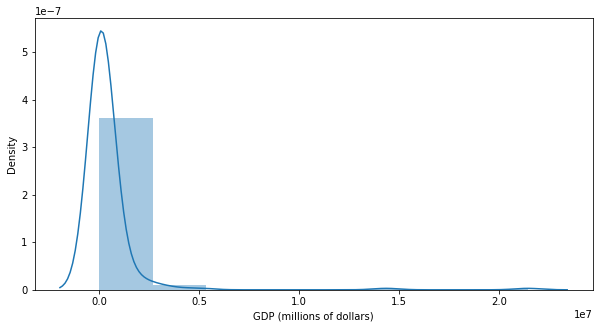

In [21]:
plt.figure(figsize = (10,5))
sns.distplot(data_complete['GDP (millions of dollars)'], bins=8) 

The GDP feature is highly skewed and have high kurtosis (the tail region may act as an outlier and is peaked). This issue will be resolved in feature engineering section.

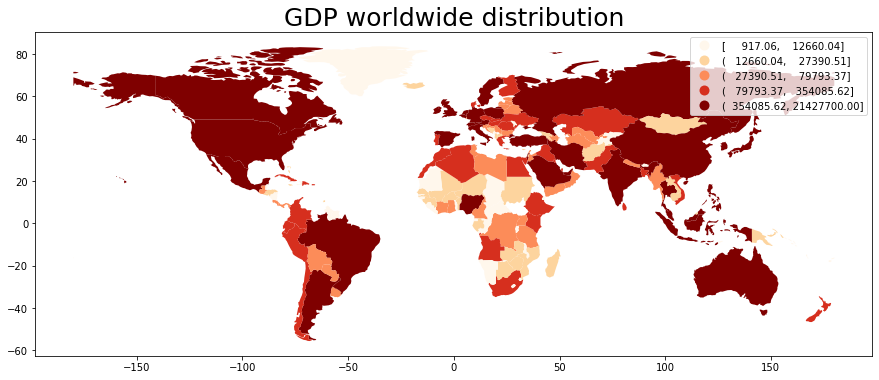

In [22]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

GDP_list = []

for code in world.iso_a3:
    if data_complete[data_complete['code']== code].empty == False:
        GDP = data_complete[data_complete['code']== code].values[0][4]
        GDP_list.append(GDP)
    else:
        GDP_list.append(None)
        
world['GDP'] = GDP_list

fig, ax = plt.subplots(figsize  = (15, 15))

ax.set_title("GDP worldwide distribution", fontsize=25)

world.plot(column='GDP', ax=ax ,legend=True, cmap='OrRd', scheme="quantiles")

As expected, the most economic powerful countries are the USA, China, Russia, etc. being Africa, some parts of Southamerica, some middle east and east of Europe more economically weak.

## Feature engineering

I will create some new features and transform another ones to empower the clustering model.

### Creating GDP per capita feature

Having the population data of each country the GDP per capita can be obtained:

In [23]:
data_fe = data_complete.copy()

In [24]:
populations.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211,55438.0,56225.0,56695.0,57032.0,57360.0,...,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,106314.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,38041754.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,31825295.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411,14375.0,15370.0,16412.0,17469.0,18549.0,...,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,77142.0,NaN


In [25]:
populations = populations[['Country Code',2019]]

GDP_percapita = []

for code in data_fe['code']:
    if populations[populations['Country Code']== code].empty == False:
        GDP = data_fe[data_fe['code']== code].values[0][4]
        population = populations[populations['Country Code']== code].values[0][1]
        # I want to avoid negative or 0 values and to not lose all country information I will input 0.00001 in this case
        if (GDP/population) < 0.0:
            GDP_percapita.append(None)
        else:
            GDP_percapita.append(GDP/population)
    else:
        GDP_percapita.append(None)
        
data_fe['GDP_percapita (millions of dollars)'] = GDP_percapita 

In [26]:
data_fe

,Country Name,code,lat,lon,GDP (millions of dollars),GDP_percapita (millions of dollars)
0,United States,USA,38.0000,-97.0000,2.142770e+07,0.065281
1,China,CHN,35.0000,105.0000,1.434290e+07,0.010262
2,Japan,JPN,36.0000,138.0000,5.081770e+06,0.040247
3,Germany,DEU,51.0000,9.0000,3.845630e+06,0.046259
4,India,IND,20.0000,77.0000,2.875142e+06,0.002104
...,...,...,...,...,...,...
196,Palau,PLW,7.5000,134.5000,2.839949e+02,0.015770
197,Marshall Islands,MHL,9.0000,168.0000,2.212780e+02,0.003764
198,Kiribati,KIR,1.4167,173.0000,1.946472e+02,0.001655
199,Nauru,NRU,-0.5333,166.9167,1.182234e+02,0.009397


### Dropping missing data

Clustering algorithm cant handle missing data for its calculations so lets check the missing data values:

In [27]:
total = data_fe.isnull().sum().sort_values(ascending=False)
percent = (data_fe.isnull().sum()/data_fe.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
GDP_percapita (millions of dollars),11,0.054726
GDP (millions of dollars),0,0.000000
lon,0,0.000000
lat,0,0.000000
code,0,0.000000
Country Name,0,0.000000


Due to the low number of missing data (generated because population of specific countries were missing) I will drop that rows which contain them.

In [28]:
data_fe.shape

(201, 6)

In [29]:
data_fe = data_fe[data_fe['GDP_percapita (millions of dollars)'].notna()]

In [30]:
data_fe.shape

(190, 6)

### Transform skewed data 

I want to revisit the data distributions as I created new ones:

In [31]:
data_fe_transformed = data_fe.copy()

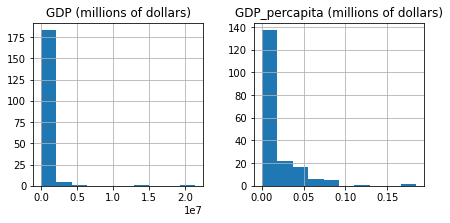

In [32]:
data_distribution = data_fe_transformed[['GDP (millions of dollars)', 'GDP_percapita (millions of dollars)']].hist(figsize=(7,3))

For enpowering the clustering algorithm I will transform the most skewed features ( GDP, GDP per capita) to reshaped them like a normal distribution since K means asumes equal mean and variance and normal distribution have mean and variance equal to 0 or close.

In [33]:
for column in ['GDP (millions of dollars)', 'GDP_percapita (millions of dollars)']:
    data_fe_transformed[column] = np.log10(data_fe_transformed[column])

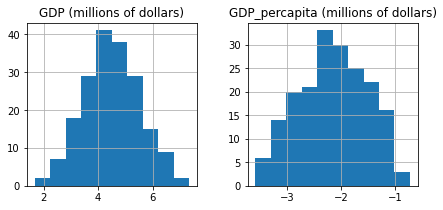

In [34]:
data_distribution = data_fe_transformed[['GDP (millions of dollars)', 'GDP_percapita (millions of dollars)']].hist(figsize=(7,3))

In [35]:
data_fe_transformed[['GDP (millions of dollars)', 'GDP_percapita (millions of dollars)']].describe()

,GDP (millions of dollars),GDP_percapita (millions of dollars)
count,190.000000,190.000000
mean,4.511640,-2.148509
std,1.036165,0.630910
min,1.674599,-3.582948
25%,3.783349,-2.594339
50%,4.459554,-2.143459
75%,5.302755,-1.649355
max,7.330976,-0.734041


This features dont have the same mean and standard deviation so I will:

- Center the variables by subtracting average value from each observation.
- Scaling variables dividing them by the standard deviation of each.

MinMaxScaler from sklearn can do the job.

In [36]:
cols = ['GDP (millions of dollars)', 'GDP_percapita (millions of dollars)']

In [37]:
scaler =  MinMaxScaler()
data_fe_transformed[cols] = scaler.fit_transform(data_fe_transformed[cols])

data_fe_transformed[cols].describe()

,GDP (millions of dollars),GDP_percapita (millions of dollars)
count,190.000000,190.000000
mean,0.501565,0.503505
std,0.183185,0.221457
min,0.000000,0.000000
25%,0.372809,0.347013
50%,0.492357,0.505278
75%,0.641428,0.678714
max,1.000000,1.000000


Now the mean and the standard deviation are near 0.

## Clustering model

For clustering I think about two options refered to algorithms:

- K-means: allows to set the number of clusters to 10 but uses Euclidean distance for its calculations (Euclidean distance does not take into consideration the curvature of the Earth).
- DBSCAN: can use haversine distance (great circle distance between two points on the earth) which is the correct metric for geographical data, but DBSCAN does not allow more than two features (latitude and longitude) when using haversine distance.

Because I want to use both the GDP and geographical data to make the clusters, I will use first DBSCAN to obtain group labels based on geodata (latitude and longitude) using the haversine distance and then I will apply K-means to obtain the final groups based on the previous DBSCAN clustering labels and the GDP data.

### DBSCAN

In [38]:
X = data_fe_transformed[['lat', 'lon']].values

In [39]:
%%time

#epsilon parameter is the max distance that points can be from each other to be considered a cluster.
# its value must be in radians
epsilon = 1400/6371

db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(X))

Wall time: 72.1 ms


In [40]:
cluster_labels = db.labels_

cluster_labels

array([-1,  0, -1,  1,  1,  1,  1,  1,  2, -1, -1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  3,  1,  2,  1,  1,  1,  1,  1,  1,  1,  3,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  3,  1,  3,  3,  1,  1,  1,  3,  4,  1,  3,  1,  1,
        1,  1,  3,  1,  1,  3,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  3,  3,  5,  1,  1,  3,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  3,  1,
        1,  1,  1,  1,  1,  1,  6,  4,  5,  1,  3,  1,  3,  1,  3,  3,  1,
        3,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  3,  1,  3,  3, -1,  1,
        1,  5,  1,  6,  3,  1,  3,  3,  5,  5,  3,  5,  3,  5,  1,  6,  5,
        5,  5,  5], dtype=int64)

In [41]:
num_clusters = len(set(cluster_labels))

num_clusters 

8

In [42]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

data_dbscan_labels = data_fe_transformed.copy()
data_dbscan_labels['DBSCAN_labels'] = list(cluster_labels)

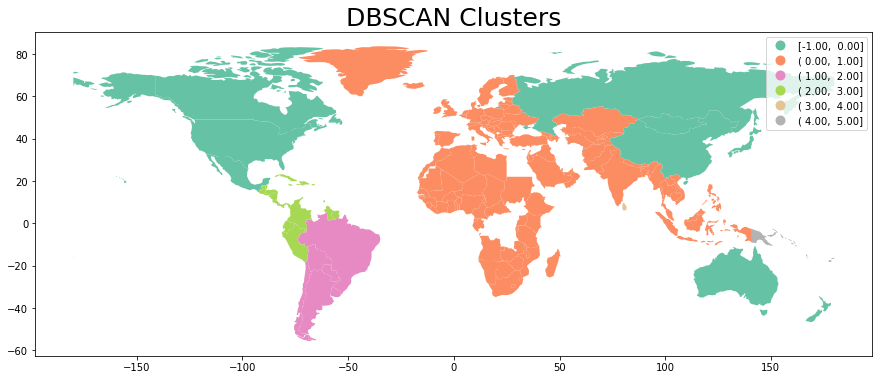

In [43]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

data_dbscan_labels = data_fe_transformed.copy()
data_dbscan_labels['DBSCAN_labels'] = list(cluster_labels)

lat_data = []
lon_data= []
labels = []

for code in world.iso_a3:
    if data_dbscan_labels[data_dbscan_labels['code']== code].empty == False:
        lat = data_dbscan_labels[data_dbscan_labels['code']== code].values[0][2]
        lon = data_dbscan_labels[data_dbscan_labels['code']== code].values[0][3]
        label = data_dbscan_labels[data_dbscan_labels['code']== code].values[0][6]
        lat_data.append(lat)
        lon_data.append(lon)
        labels.append(label)
    else:
        lat_data.append(None)
        lon_data.append(None)
        labels.append(None)
        
world['lat'] = lat_data
world['lat'] = lon_data
world['DBSCAN_labels'] = labels

fig, ax = plt.subplots(figsize  = (15, 15))

ax.set_title("DBSCAN Clusters", fontsize=25)



world.plot(column='DBSCAN_labels', ax=ax ,legend= True,
           scheme="User_Defined",  cmap='Set2', classification_kwds=dict(bins=[0,1,2,3,4]))

After some tests, this were the closest to "reasonable geographically" groups:

- More number of groups resulted in not expected segmentation (like losing differenciation between America and Europe-Africa etc and not getting ideally separation in Europe, America, Asia, etc.).

- Some locations did not converge well (-1 labels). That is the reason why the USA, Rusia, China etc. are together in the same group. This is maybe because zones like Europe , Africa, Sudamerica, etc. have more locations having more countries inside and better convergence as a result, contrary to North America or Rusia for example.

- The groups are large but in some way divided in center, east, west at least. 

I hope this information will be useful for the final clustering.

### K-means

With K-means I aim to get the final group labels based on the geographical groups thanks to the DBSCAN clustering and to the GDP data.

In [44]:
 data_dbscan_labels.head()

,Country Name,code,lat,lon,GDP (millions of dollars),GDP_percapita (millions of dollars),DBSCAN_labels
0,United States,USA,38.0,-97.0,1.000000,0.841633,-1
1,China,CHN,35.0,105.0,0.969178,0.559571,0
2,Japan,JPN,36.0,138.0,0.889512,0.767902,-1
3,Germany,DEU,51.0,9.0,0.868112,0.789125,1
4,India,IND,20.0,77.0,0.845782,0.318025,1


In [45]:
X = data_dbscan_labels.drop(['lat', 'lon','Country Name','code'], axis = 1).values

In [46]:
%%time

seed = 0

kmeans = KMeans(init='k-means++', n_clusters=10,  n_init=10, max_iter = 300, random_state=seed).fit(X)

unique, counts = np.unique(kmeans.labels_, return_counts=True)

Wall time: 97.3 ms


In [47]:
kmeans.inertia_

5.258426853603428

In [48]:
# The number of iterations required to converge
kmeans.n_iter_

6

In [49]:
kmeans.labels_

array([3, 8, 3, 4, 0, 4, 4, 4, 5, 3, 3, 4, 3, 3, 0, 4, 4, 0, 4, 4, 0, 4,
       4, 5, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 1, 0, 5, 0, 4, 0, 4, 4, 4,
       0, 1, 4, 3, 4, 0, 0, 4, 0, 4, 0, 1, 4, 1, 1, 7, 0, 0, 1, 9, 4, 1,
       7, 4, 0, 0, 1, 7, 0, 1, 4, 0, 0, 5, 4, 4, 0, 0, 0, 0, 0, 5, 0, 0,
       7, 4, 5, 7, 4, 4, 7, 7, 1, 1, 2, 4, 4, 1, 7, 7, 7, 0, 7, 7, 0, 0,
       0, 7, 0, 1, 7, 0, 7, 4, 0, 7, 0, 7, 8, 0, 7, 4, 7, 0, 1, 0, 0, 7,
       0, 7, 1, 7, 7, 7, 7, 4, 4, 4, 6, 9, 2, 0, 1, 7, 1, 0, 1, 1, 7, 1,
       7, 4, 7, 1, 4, 7, 4, 7, 7, 7, 1, 7, 1, 1, 3, 7, 4, 2, 7, 6, 1, 7,
       1, 1, 2, 2, 1, 2, 1, 2, 7, 6, 2, 2, 2, 2])

### Clustering evaluation: ideal number of clusters

#### Elbow method

Although 10 clusters was the initial objective, the optimal number of clusters can be obtained using the elbow method:  consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

In [50]:
 kmeans_kwargs = {
     "init": "k-means++",
     "n_init": 10,
     "max_iter": 300,
     "random_state": seed}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

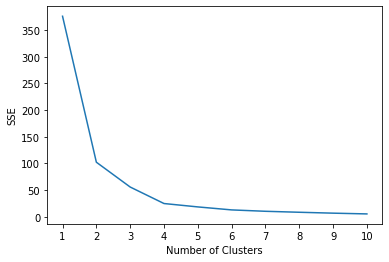

In [51]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The elbow point is maybe at 2, 3, 4 clusters.

With kneed library, which apply the kneedle algorithm, the elbow point can be obtained programmatically:

In [52]:
from kneed import DataGenerator, KneeLocator

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

3

#### Silhouette coefficients

The silhouette coefficient is a measure of cluster cohesion and separation based on:
- How close the data point is to other points in the cluster
- How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [53]:
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

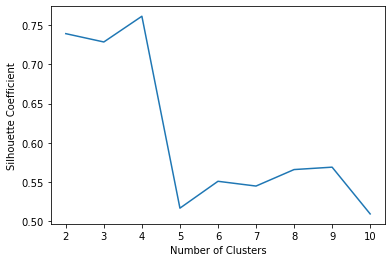

In [54]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

The best number os clusters by silhouette coefficient is 4.

## Final output and cluster discussion

### Final output

Finally I will add the K-means cluster labels to the data as a feature:

In [55]:
results = data_fe.copy()
results = results[['GDP_percapita (millions of dollars)', 'GDP (millions of dollars)', 'code', 'Country Name']]
results['group_label'] = kmeans.labels_

In [56]:
results.head()

,GDP_percapita (millions of dollars),GDP (millions of dollars),code,Country Name,group_label
0,0.065281,2.142770e+07,USA,United States,3
1,0.010262,1.434290e+07,CHN,China,8
2,0.040247,5.081770e+06,JPN,Japan,3
3,0.046259,3.845630e+06,DEU,Germany,4
4,0.002104,2.875142e+06,IND,India,0


I will create the required features:
    
- **Group average GDP per capita.**
- **Cumulative GDP fraction (0 to 1) within the group** (after ordering by Group average GDP per capita and country's total GDP ).

In [57]:
GDP_pc_average_dict = {0: None,
                1: None,
                2: None,
                3: None,
                4: None,
                5: None,
                6: None,
                7: None,
                8: None,
                9: None}

for group in range(0,10):
    group_filter = results[results['group_label'] == group]['GDP_percapita (millions of dollars)']
    average = group_filter.sum() / len(group_filter)
    GDP_pc_average_dict[group] = average

GDP_pc_average = []

for group in results['group_label']:
    GDP_pc_average.append(GDP_pc_average_dict[group])
    
results['Group average GDP per capita'] = GDP_pc_average

In [58]:
results.head()

,GDP_percapita (millions of dollars),GDP (millions of dollars),code,Country Name,group_label,Group average GDP per capita
0,0.065281,2.142770e+07,USA,United States,3,0.035969
1,0.010262,1.434290e+07,CHN,China,8,0.007278
2,0.040247,5.081770e+06,JPN,Japan,3,0.035969
3,0.046259,3.845630e+06,DEU,Germany,4,0.047408
4,0.002104,2.875142e+06,IND,India,0,0.005281


Before create the Cumulative GDP fraction feature I have to order the data:
- By group label ranked by average GDP per capita.
- By GDP inside each group.

In [59]:
# By group label ranked by GDP average per capita
results['max'] = results.groupby('group_label')['Group average GDP per capita'].transform('max')
# By GDP inside each group
results['max2'] = results.groupby('max')['GDP (millions of dollars)'].transform('max')

results = results.sort_values(["max","max2"], ascending=False).drop(['max','max2'], axis=1)

results = results[['Country Name','code', 'group_label', 'Group average GDP per capita',
                   'GDP_percapita (millions of dollars)', 'GDP (millions of dollars)']]

results

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars)
3,Germany,DEU,4,0.047408,0.046259,3.845630e+06
5,United Kingdom,GBR,4,0.047408,0.042300,2.827113e+06
6,France,FRA,4,0.047408,0.040494,2.715518e+06
7,Italy,ITA,4,0.047408,0.033190,2.001244e+06
12,Spain,ESP,4,0.047408,0.029614,1.394116e+06
...,...,...,...,...,...,...
174,Cabo Verde,CPV,7,0.001160,0.003604,1.981846e+03
179,Timor-Leste,TLS,7,0.001160,0.001294,1.673540e+03
182,Guinea-Bissau,GNB,7,0.001160,0.000698,1.340389e+03
185,Comoros,COM,7,0.001160,0.001394,1.185729e+03


Now I can create the cumulative GDP fraction:

In [60]:
cumulative_GDP = []

GDP_by_group = {0:None,
                1:None,
                2:None,
                3:None,
                4:None,
                5:None,
                6:None,
                7:None,
                8:None,
                9:None}

for group in range(0,10):
    total = results[results['group_label'] == group]['GDP (millions of dollars)'].sum()
    GDP_by_group[group] = total
    
for country, group in zip(results['GDP (millions of dollars)'], results['group_label']):
    fraction = country/GDP_by_group[group]
    cumulative_GDP.append(fraction )
    
results['Cumulative GDP fraction'] = cumulative_GDP

In [61]:
results

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
3,Germany,DEU,4,0.047408,0.046259,3.845630e+06,0.175261
5,United Kingdom,GBR,4,0.047408,0.042300,2.827113e+06,0.128843
6,France,FRA,4,0.047408,0.040494,2.715518e+06,0.123757
7,Italy,ITA,4,0.047408,0.033190,2.001244e+06,0.091205
12,Spain,ESP,4,0.047408,0.029614,1.394116e+06,0.063536
...,...,...,...,...,...,...,...
174,Cabo Verde,CPV,7,0.001160,0.003604,1.981846e+03,0.002997
179,Timor-Leste,TLS,7,0.001160,0.001294,1.673540e+03,0.002531
182,Guinea-Bissau,GNB,7,0.001160,0.000698,1.340389e+03,0.002027
185,Comoros,COM,7,0.001160,0.001394,1.185729e+03,0.001793


### Cluster discussion

Final groups order

In [62]:
results['group_label'].unique().tolist()

[4, 3, 6, 1, 5, 9, 8, 0, 2, 7]

### First sorted Group

Lets analize the first group sorted by Group average GDP per capita:

In [63]:
filtered_group = results[results['group_label'] == 4]

filtered_group 

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
3,Germany,DEU,4,0.047408,0.046259,3.845630e+06,0.175261
5,United Kingdom,GBR,4,0.047408,0.042300,2.827113e+06,0.128843
6,France,FRA,4,0.047408,0.040494,2.715518e+06,0.123757
7,Italy,ITA,4,0.047408,0.033190,2.001244e+06,0.091205
12,Spain,ESP,4,0.047408,0.029614,1.394116e+06,0.063536
16,Netherlands,NLD,4,0.047408,0.052448,9.090704e+05,0.041430
17,Saudi Arabia,SAU,4,0.047408,0.023140,7.929668e+05,0.036139
19,Switzerland,CHE,4,0.047408,0.081994,7.030824e+05,0.032042
20,Poland,POL,4,0.047408,0.015595,5.921644e+05,0.026987
22,Sweden,SWE,4,0.047408,0.051610,5.308329e+05,0.024192


- The group with the highest average GDP per capita have countries with geographical proximity (mostly european zone countries)

- Their GDP are big.

I will use historial GDP to analize better this groups:

In [64]:
GDP_historical = pd.read_excel("GDP_historical.xlsx", encoding='utf-8')

group_names = filtered_group['Country Name'].tolist()

GDP_historical_filter = GDP_historical[GDP_historical['Country Name'].isin(group_names)]

GDP_historical_filter = GDP_historical_filter.iloc[:,34:]

GDP_historical_filter['Country Name'] = group_names

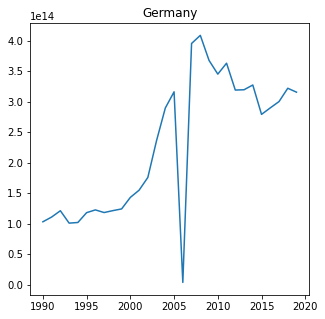

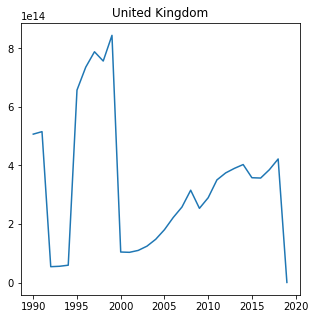

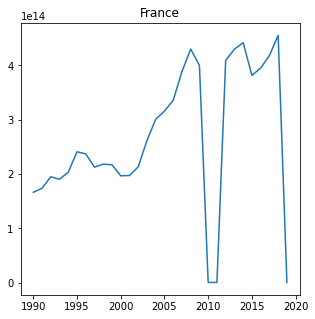

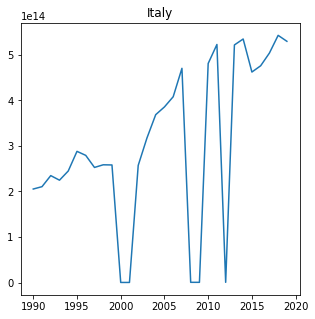

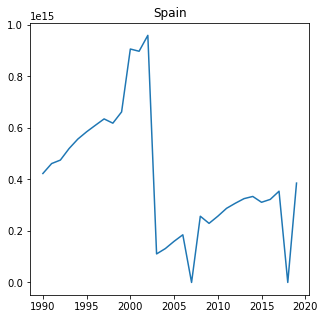

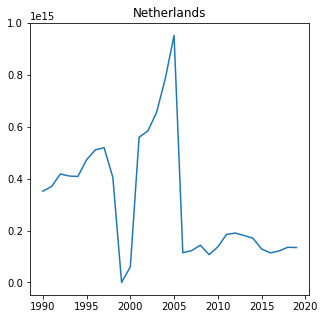

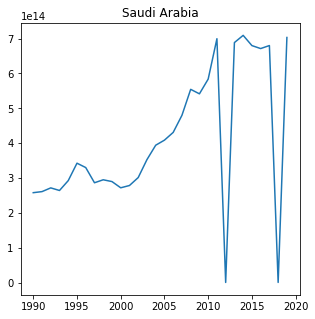

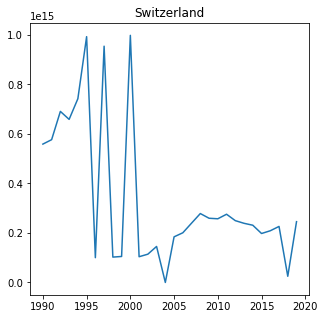

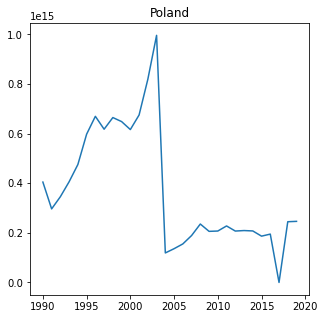

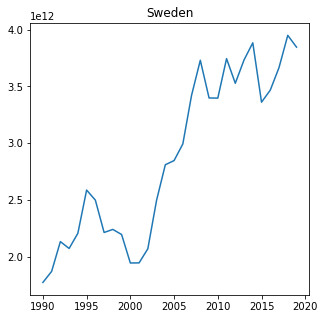

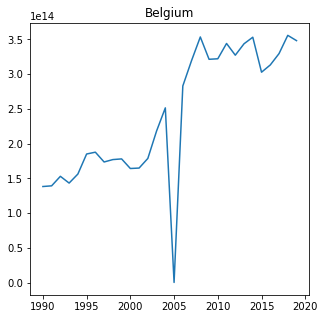

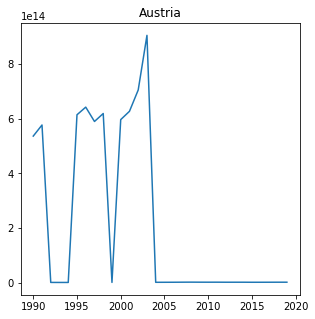

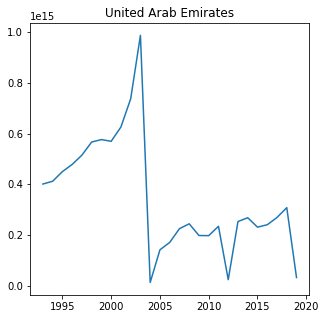

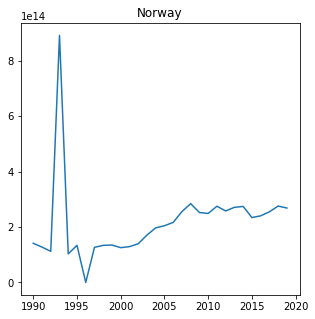

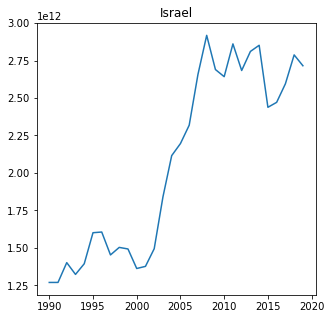

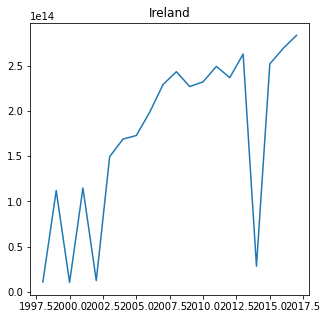

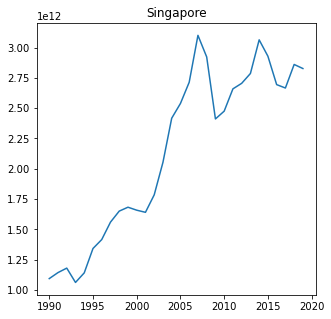

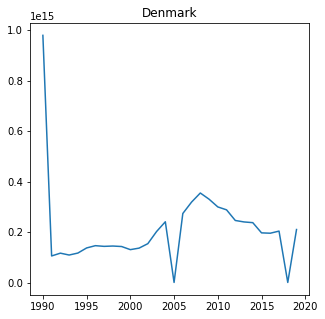

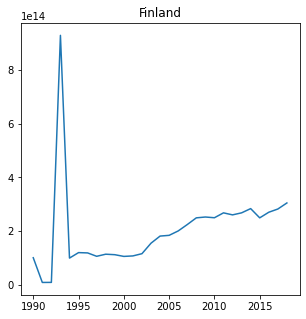

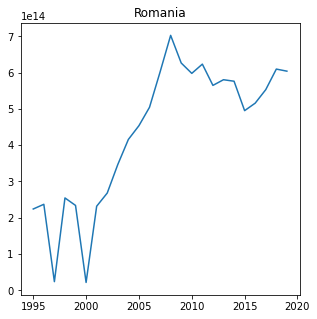

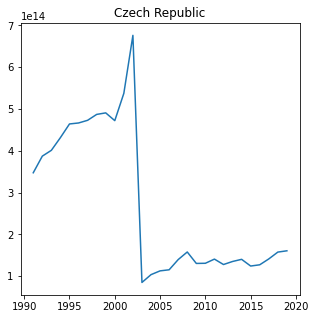

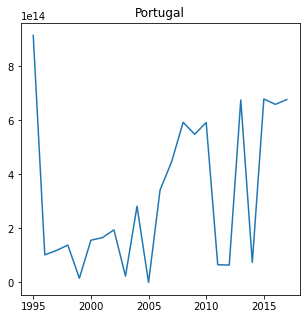

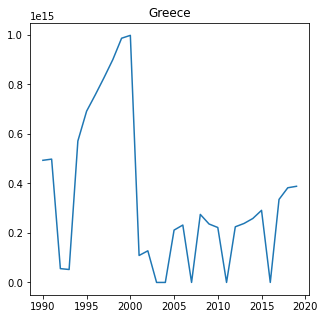

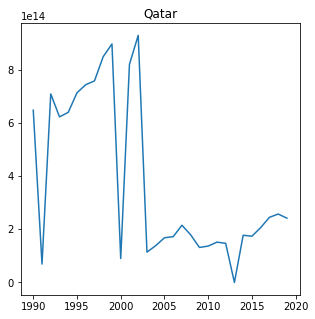

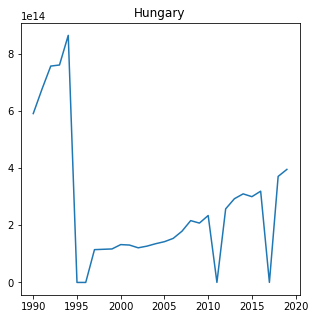

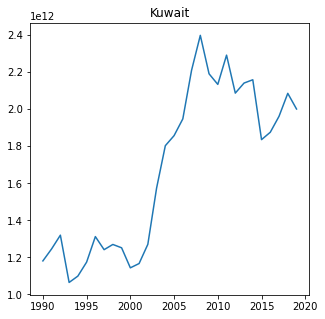

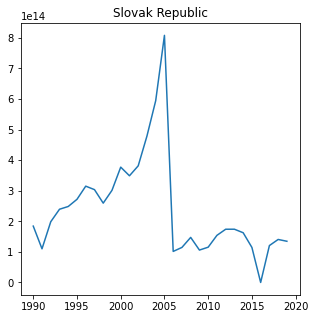

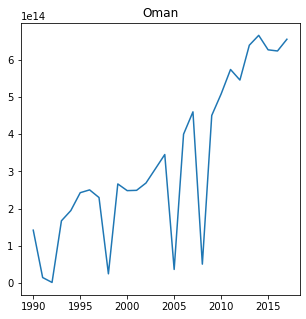

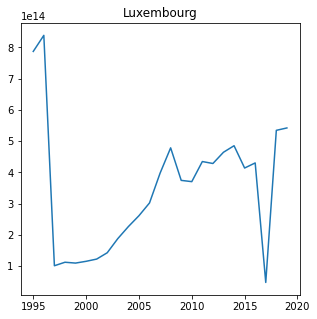

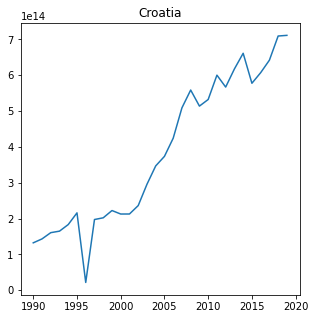

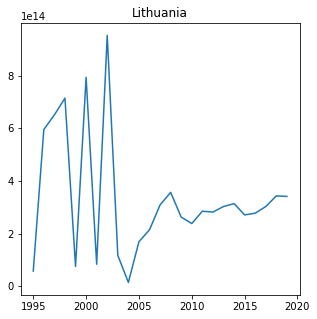

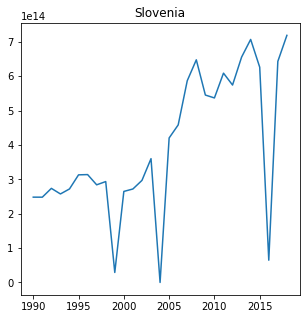

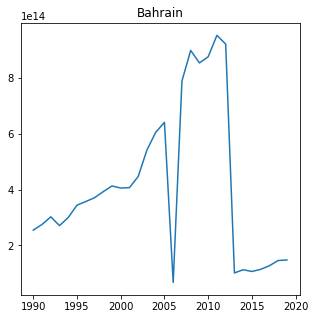

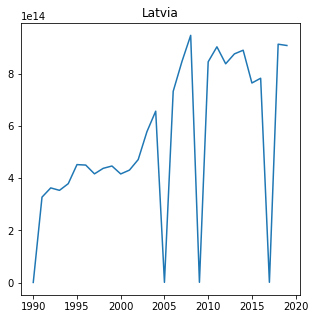

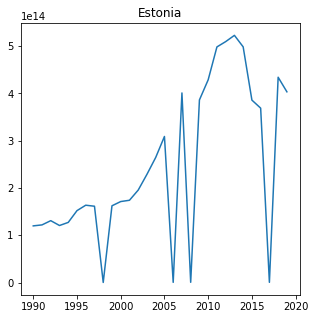

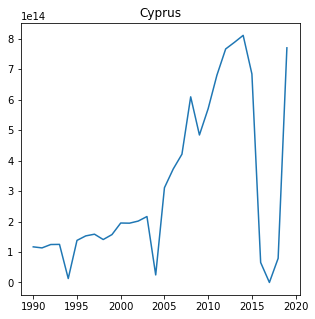

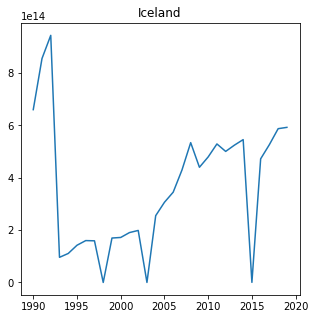

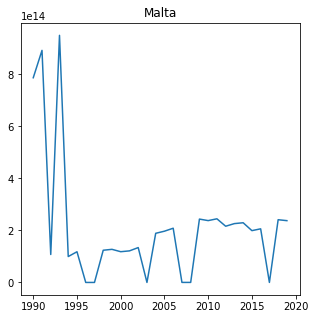

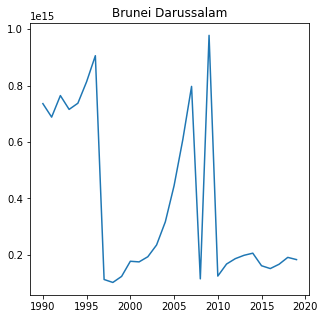

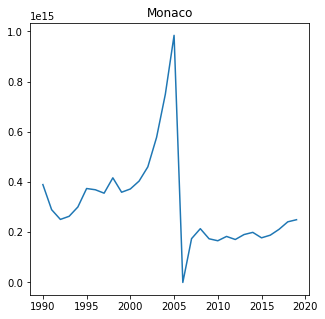

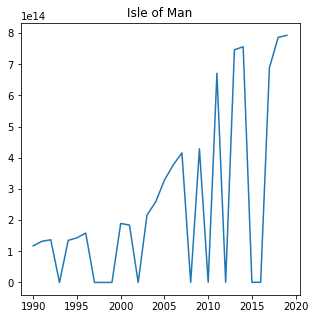

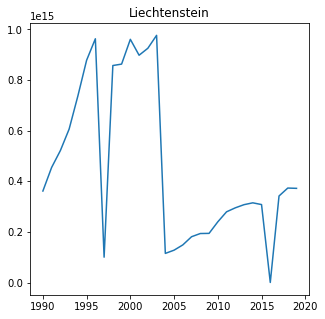

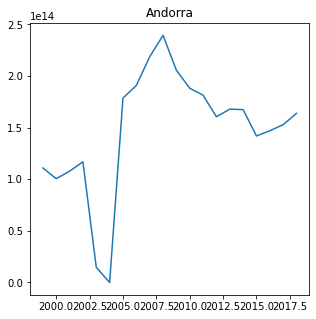

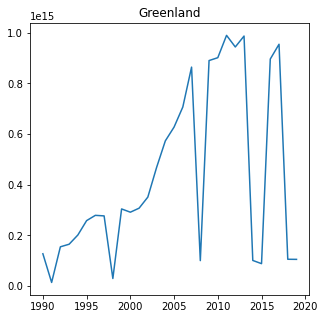

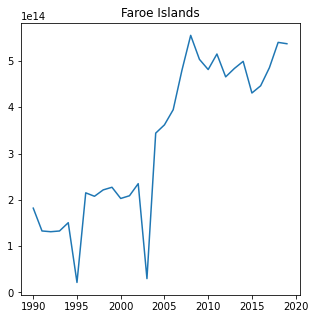

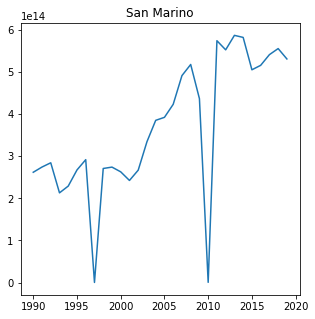

In [65]:
rows = GDP_historical_filter.shape[1]-2

df = GDP_historical_filter.T.iloc[0:rows,:]

for name, column in zip(group_names, df.columns.tolist()):
    plt.figure(figsize=(5,5))
    df[column].plot()
    plt.title(name)
    plt.show()
    

- It makes sense Germany, UK, France, etc. are in the same group because they have strong economies.

- Spain and Italy are also in this group because geographical proximity and their growing GDP in the last years.

- There are also non-european rich countries like Israel, Singapore, Qatar, etc. This is maybe due to the DBSCAN clustering which have a group formed by Europe + Africa + Middle-east.

### Groups cointaining USA, China

In [66]:
results[results['code'] == 'USA']

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
0,United States,USA,3,0.035969,0.065281,21427700.0,0.653177


In [67]:
filtered_group = results[results['group_label'] == 3]

filtered_group 

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
0,United States,USA,3,0.035969,0.065281,2.142770e+07,0.653177
2,Japan,JPN,3,0.035969,0.040247,5.081770e+06,0.154907
9,Canada,CAN,3,0.035969,0.046195,1.736426e+06,0.052931
10,Russian Federation,RUS,3,0.035969,0.011774,1.699877e+06,0.051817
13,Australia,AUS,3,0.035969,0.054907,1.392681e+06,0.042453
14,Mexico,MEX,3,0.035969,0.009863,1.258287e+06,0.038356
51,New Zealand,NZL,3,0.035969,0.042084,2.069288e+05,0.006308
178,Seychelles,SYC,3,0.035969,0.017402,1.698843e+03,0.000052


- In this group there are strong economies such USA, Japan, Canada, Russia, Australia, Mexico...

- Its grouping may had a huge conditioning because DBSCAN clustering did not distinguis well between America and Asia as comented before.

In [68]:
group_names = filtered_group['Country Name'].tolist()

GDP_historical_filter = GDP_historical[GDP_historical['Country Name'].isin(group_names)]

GDP_historical_filter = GDP_historical_filter.iloc[:,34:]

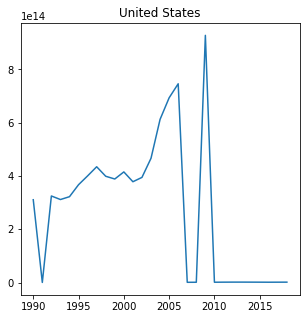

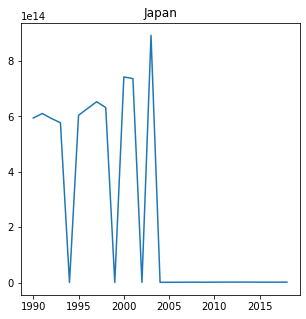

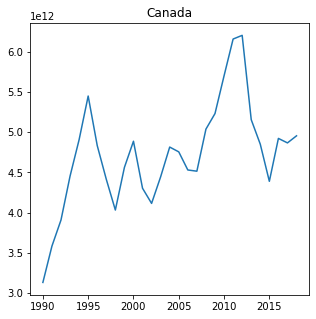

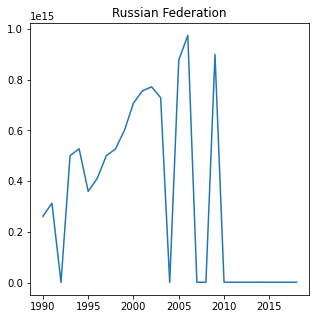

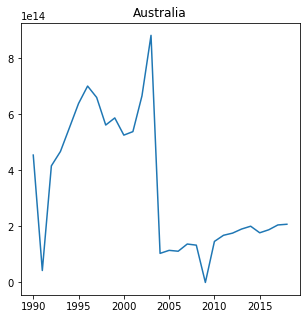

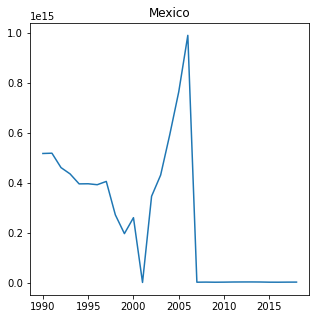

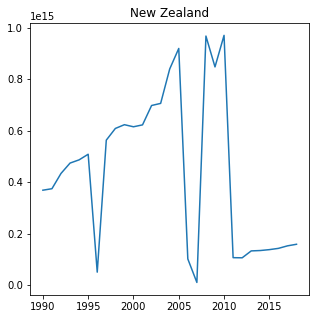

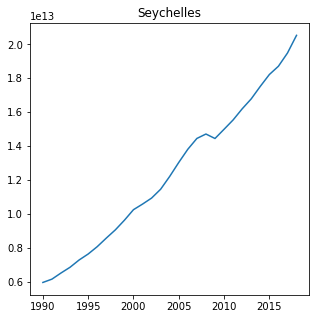

In [69]:
rows = GDP_historical_filter.shape[1]-2

df = GDP_historical_filter.T.iloc[0:rows,:]

for name, column in zip(group_names, df.columns.tolist()):
    plt.figure(figsize=(5,5))
    df[column].plot()
    plt.title(name)
    plt.show()
    

- In general their GDPs growed weakly the last years except from the Seychelles.

- Geographically they were in the same DBSCAN clustering group (North America, Japan, Rusia, etc.) being these clustering labels highly conditional.

Lets explore China group:

In [70]:
results[results['Country Name'] == 'China']

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
1,China,CHN,8,0.007278,0.010262,1.434290e+07,0.999035


In [71]:
filtered_group = results[results['group_label'] == 8]

filtered_group 

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
1,China,CHN,8,0.007278,0.010262,1.434290e+07,0.999035
129,Mongolia,MNG,8,0.007278,0.004295,1.385285e+04,0.000965


- It is clear China and Mongolia are in the same group because proximity although China have a bigger GDP.

In [72]:
group_names = filtered_group['Country Name'].tolist()

GDP_historical_filter = GDP_historical[GDP_historical['Country Name'].isin(group_names)]

GDP_historical_filter = GDP_historical_filter.iloc[:,34:]

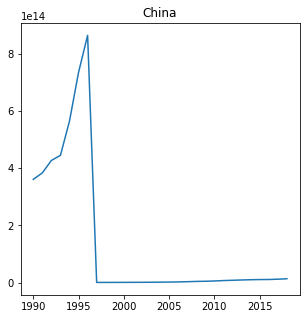

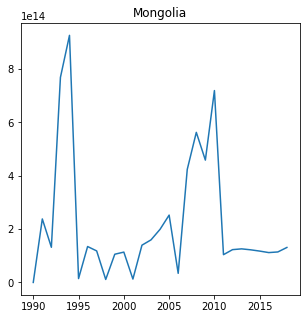

In [73]:
rows = GDP_historical_filter.shape[1]-2

df = GDP_historical_filter.T.iloc[0:rows,:]

for name, column in zip(group_names, df.columns.tolist()):
    plt.figure(figsize=(5,5))
    df[column].plot()
    plt.title(name)
    plt.show()
    

- The China GDP growth is surprisingly low through the last years.

### The last group

In [74]:
filtered_group = results[results['group_label'] == 7]

filtered_group 

,Country Name,code,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
63,Ethiopia,ETH,7,0.00116,0.000858,96107.662398,0.145325
70,Myanmar,MMR,7,0.00116,0.001408,76085.852617,0.115050
75,Tanzania,TZA,7,0.00116,0.001089,63177.068175,0.095530
94,Cameroon,CMR,7,0.00116,0.001498,38760.467033,0.058610
97,Uganda,UGA,7,0.00116,0.000777,34387.229486,0.051997
100,Nepal,NPL,7,0.00116,0.001071,30641.380604,0.046333
102,Cambodia,KHM,7,0.00116,0.001643,27089.389787,0.040962
109,Senegal,SEN,7,0.00116,0.001447,23578.084052,0.035653
110,Zambia,ZMB,7,0.00116,0.001291,23064.722446,0.034876
111,Zimbabwe,ZWE,7,0.00116,0.001464,21440.758800,0.032421


- The last group contains essentially African countries with some Asian countries which makes sense due to they do not have strong economies.

In [75]:
group_names = filtered_group['Country Name'].tolist()

GDP_historical_filter = GDP_historical[GDP_historical['Country Name'].isin(group_names)]

GDP_historical_filter = GDP_historical_filter.iloc[:,34:]

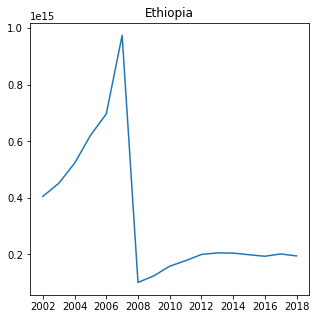

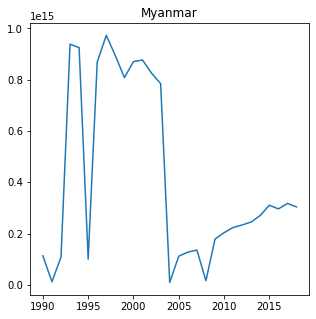

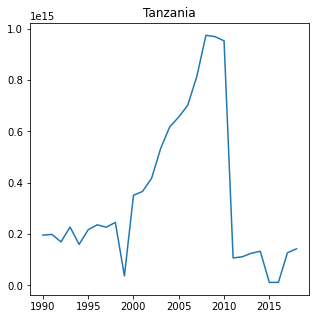

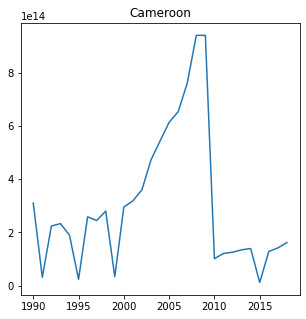

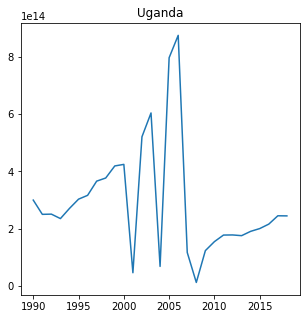

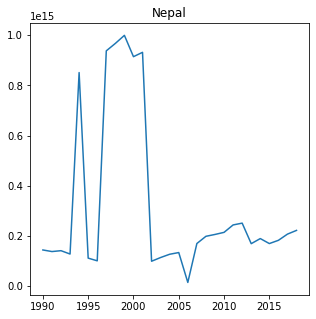

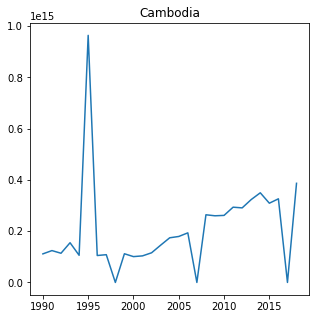

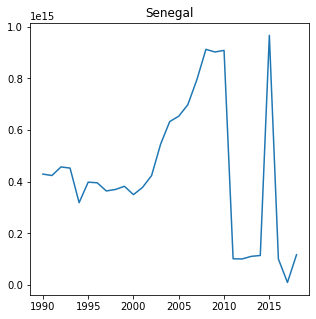

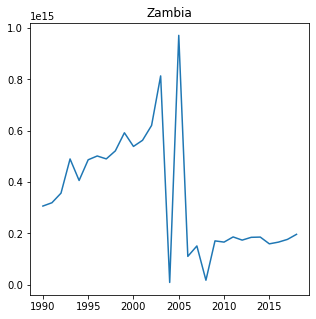

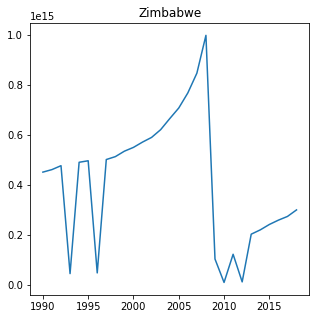

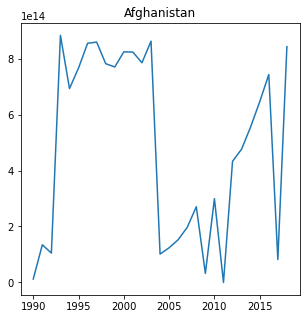

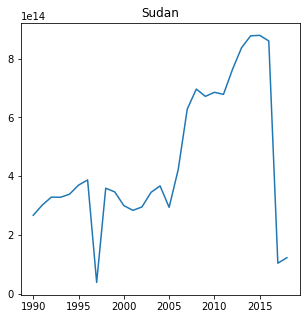

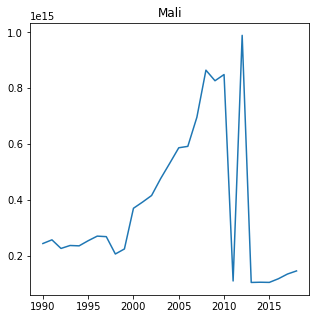

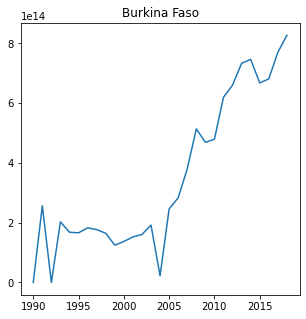

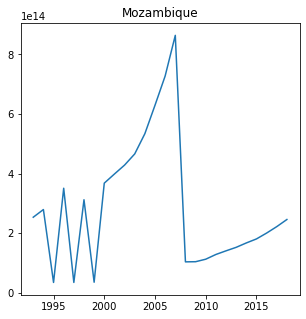

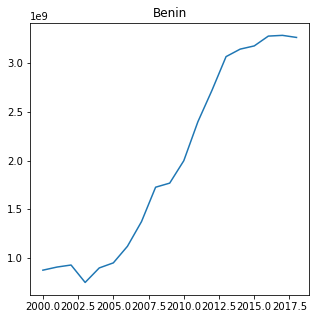

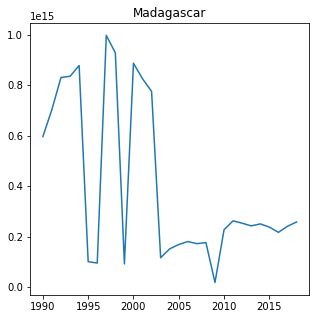

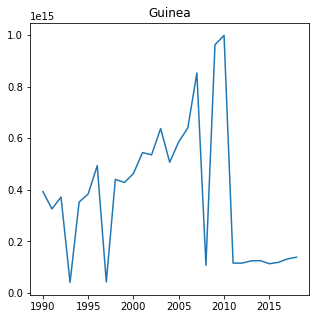

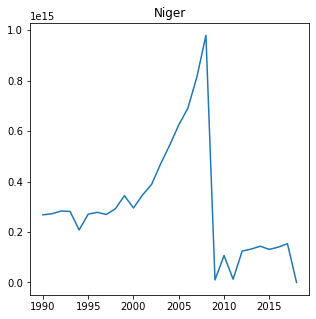

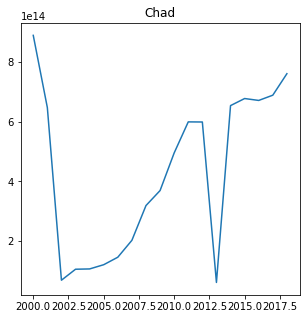

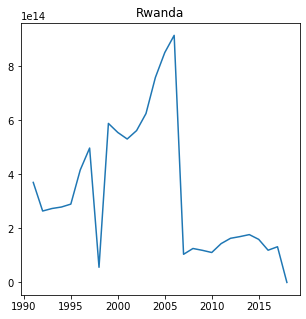

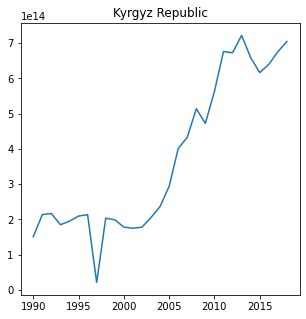

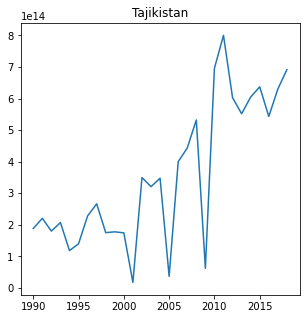

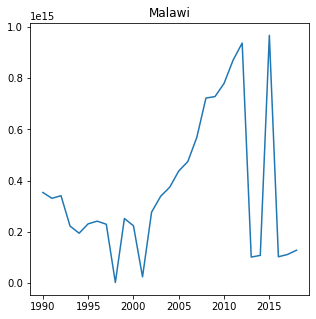

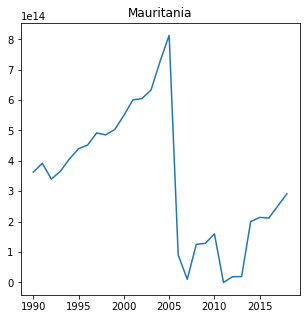

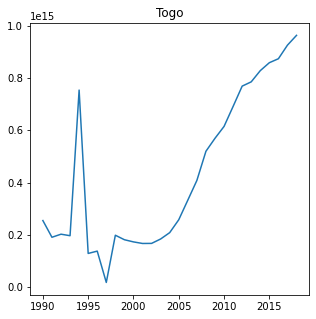

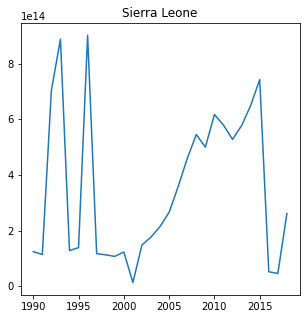

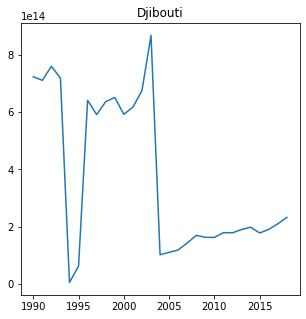

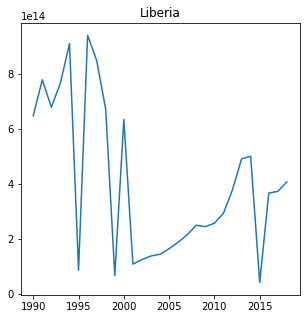

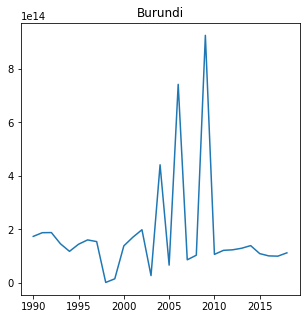

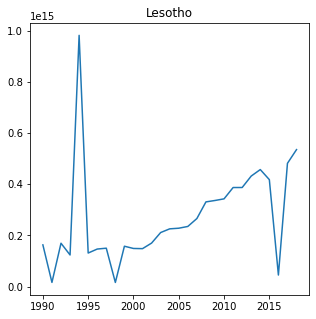

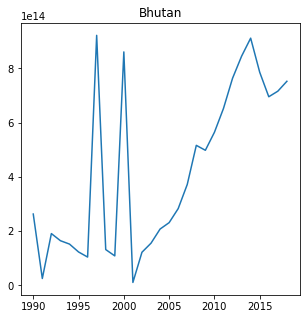

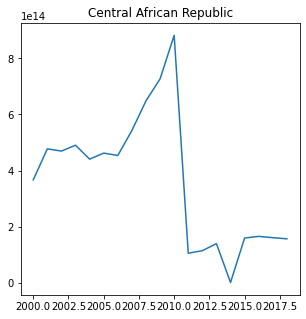

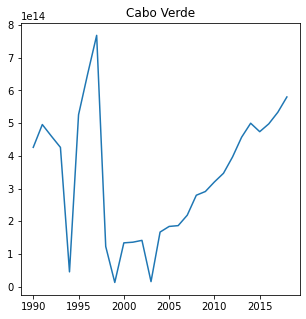

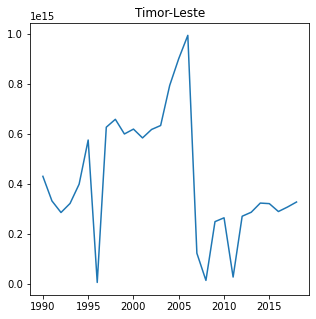

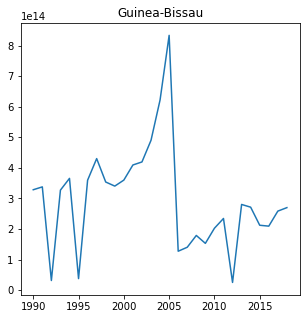

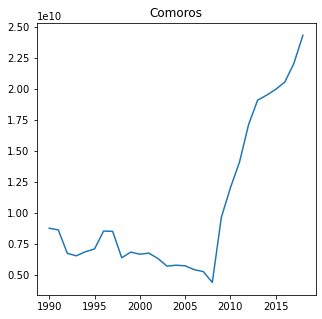

In [76]:
rows = GDP_historical_filter.shape[1]-2

df = GDP_historical_filter.T.iloc[0:rows,:]

for name, column in zip(group_names, df.columns.tolist()):
    plt.figure(figsize=(5,5))
    df[column].plot()
    plt.title(name)
    plt.show()
    

- In general their GDPs are growing but their GPD per capita is very low.

## Conclusions

- Final groups makes sense in terms of grouping after seeing DBSCAN clustering and taking into account their GDPs although it is clear the final groups are not ideal.

- The DBSCAN clustering  labels were critical in the K-means clustering calculation, having this labels a lot of weight.

- The GDP is highly concentrated in only one country in some groups (USA, China, etc.).

## Further improvement

- Investigate more the DBSCAN algorithm in terms of giving more weight to locations with bigger areas (USA, Russia, etc.)

- Try another clustering algorithms to see if they suit better this task.

- Search for another ways around how to implement geographical data in clustering combined with other non-geographical features.

- Think about the creation of new features which may help in the clustering.

### Results to csv

In [77]:
results.drop('code', axis = 1, inplace = True)

In [78]:
results.head()

,Country Name,group_label,Group average GDP per capita,GDP_percapita (millions of dollars),GDP (millions of dollars),Cumulative GDP fraction
3,Germany,4,0.047408,0.046259,3.845630e+06,0.175261
5,United Kingdom,4,0.047408,0.042300,2.827113e+06,0.128843
6,France,4,0.047408,0.040494,2.715518e+06,0.123757
7,Italy,4,0.047408,0.033190,2.001244e+06,0.091205
12,Spain,4,0.047408,0.029614,1.394116e+06,0.063536


In [79]:
results.to_csv(r'geo-economic-clustering.csv', index = False)